# Discrete Key-Value Bottleneck: A Simple Learning Setting Motivating the Method

We consider a 2D input feature classification problem for 8
classes, where the training data is not i.i.d. but changes over
four stages. In each stage, we sample 100
examples of two classes for 1000 training steps, using gradient descent to update the weights, then move on to two new
classes for the next 1000 steps. The input features of each
class follow spatially separated normal distributions.



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
# from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
NUM_CLASSES = 8
INPUT_DIM = 2
OUTPUT_DIM = 8
SAMPLES_PER_CLASS = 100

NUM_EPOCHS = 1000

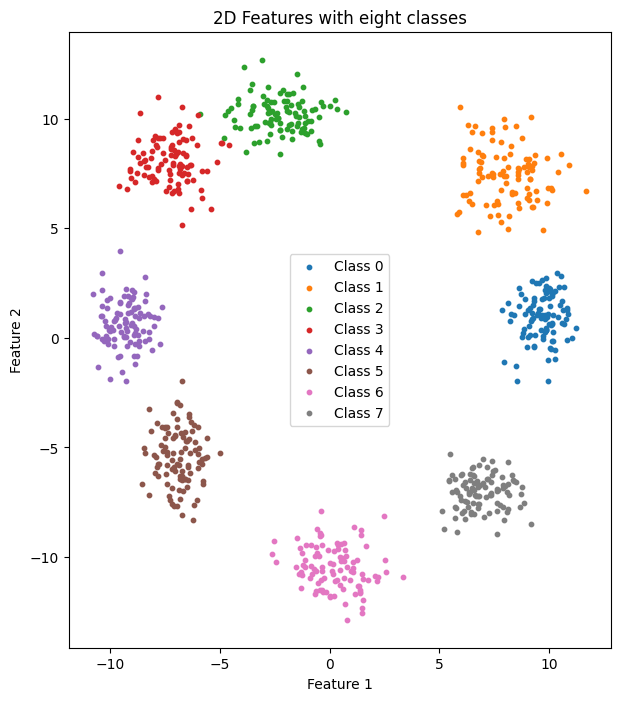

In [3]:
df = pd.read_csv("Toy Synthetic Dataset.csv")
df.drop(columns="Unnamed: 0", inplace=True)

# scaler = MinMaxScaler()
# df[['Feature_1', 'Feature_2']] = scaler.fit_transform(df[['Feature_1', 'Feature_2']])

plt.figure(figsize=(8, 8))
for i in range(NUM_CLASSES):
    plt.scatter(df[df["Labels"] == i]["Feature_1"], df[df["Labels"] == i]["Feature_2"], 
                label=f'Class {i}', s=10)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Features with eight classes')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
X = torch.tensor(df.drop(columns="Labels").to_numpy(), dtype=float)
y = torch.tensor(df["Labels"].to_numpy())

### **Function to display the decision boundaries**

In [5]:
def plot_datapoints_and_decision_boundary(model, X, y, lim=15, h=0.05):
    model.eval()

    cmap_light = ListedColormap(plt.get_cmap('Pastel1', 8).colors)
    cmap_bold = ListedColormap(plt.get_cmap('Set1', 8).colors)
    
    x_min, x_max = X[:, 0].min() - lim, X[:, 0].max() + lim
    y_min, y_max = X[:, 1].min() - lim, X[:, 1].max() + lim
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h, dtype=np.float32),
                         np.arange(y_min, y_max, h, dtype=np.float32))
    
    input_data = np.c_[xx.ravel(), yy.ravel()]
    
    with torch.no_grad():
        Z = model(torch.tensor(input_data).float())
        Z = torch.argmax(Z, dim=1).numpy().reshape(xx.shape)
        print("The classes being predicted by the model are: ", torch.tensor(Z).unique().detach().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolors='k', s=5)
    
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary, Data Points, and Region Labels')
    plt.show()


In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
loss_criterion = nn.CrossEntropyLoss()

def train_incrementally(num_epochs, X, y, model, loss_criterion, optimizer, min_delta=0, scheduler=None):
    
    delta = int(X.shape[0] / 2)
    # early_stopper = EarlyStopper(patience=100, min_delta=min_delta)
    
    for i in range(int(NUM_CLASSES/2)):
        print(f"Training period  {i + 1 } started")
        
        X_train = torch.vstack([X[i * SAMPLES_PER_CLASS : (i + 1) * SAMPLES_PER_CLASS], 
                                X[i * SAMPLES_PER_CLASS + delta: (i + 1) * SAMPLES_PER_CLASS + delta]]).float()
        
        y_train = torch.vstack([y[i * SAMPLES_PER_CLASS : (i + 1) * SAMPLES_PER_CLASS], 
                                y[i * SAMPLES_PER_CLASS + delta: (i + 1) * SAMPLES_PER_CLASS + delta]])
        y_train = y_train.reshape(2 * SAMPLES_PER_CLASS)
        print(f"Classes being trained on are: {y_train.unique().tolist()}")
        
        dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
        
        running_loss = 0.0
        losses = []
        last_epoch = None
        
        for epoch in range(num_epochs):
            for inputs, labels in train_loader:

                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                running_loss += loss.item()

                optimizer.zero_grad() 
                loss.backward() 
                optimizer.step()  
            
            losses.append(running_loss)
            # if early_stopper.early_stop(losses[-1]):             
            #     break

            if epoch % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.4f}')
                
            last_epoch = epoch

        print(f"Training period { i + 1 } completed; last epoch run = { last_epoch + 1 }")
        
        # plt.plot(losses)
        # plt.xlabel("Epochs")
        # plt.ylabel("Training Loss")

        plot_datapoints_and_decision_boundary(model, X_train.detach().numpy(), y_train.detach().numpy())

In [8]:
def init_weights_to_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias) 
            
def init_weights_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [9]:
class LinearProbe(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear_layer = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        z = self.linear_layer(x)
        return z

Training period  1 started
Classes being trained on are: [0, 4]
Epoch 1/1000, Loss: 0.0091
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0001
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 1 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 1 4]


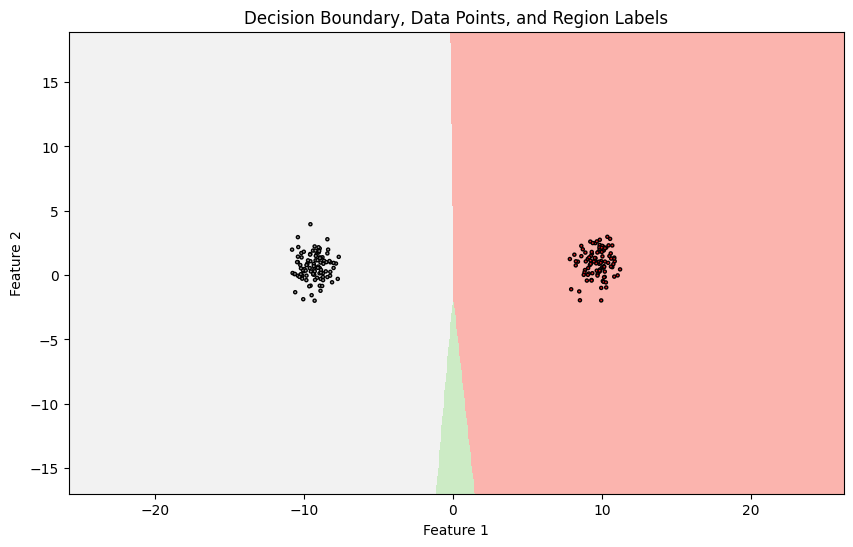

Training period  2 started
Classes being trained on are: [1, 5]
Epoch 1/1000, Loss: 0.0073
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0001
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0001
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 2 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 1 4 5]


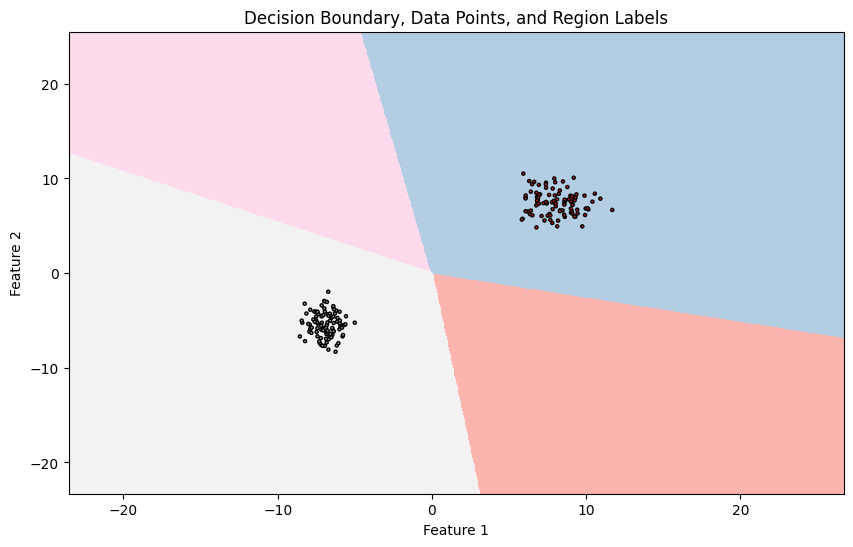

Training period  3 started
Classes being trained on are: [2, 6]
Epoch 1/1000, Loss: 0.0055
Epoch 101/1000, Loss: 0.0002
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 3 completed; last epoch run = 1000
The classes being predicted by the model are:  [1 2 5 6]


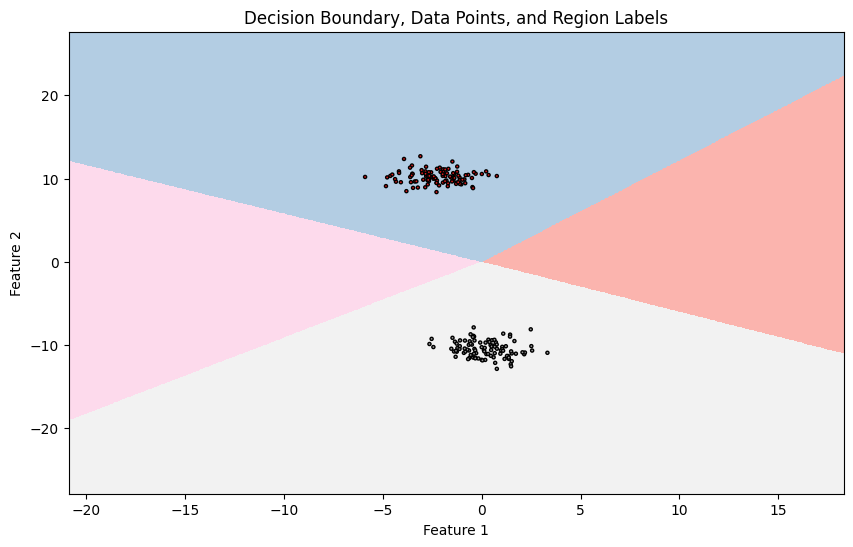

Training period  4 started
Classes being trained on are: [3, 7]
Epoch 1/1000, Loss: 0.0042
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 4 completed; last epoch run = 1000
The classes being predicted by the model are:  [1 3 5 6 7]


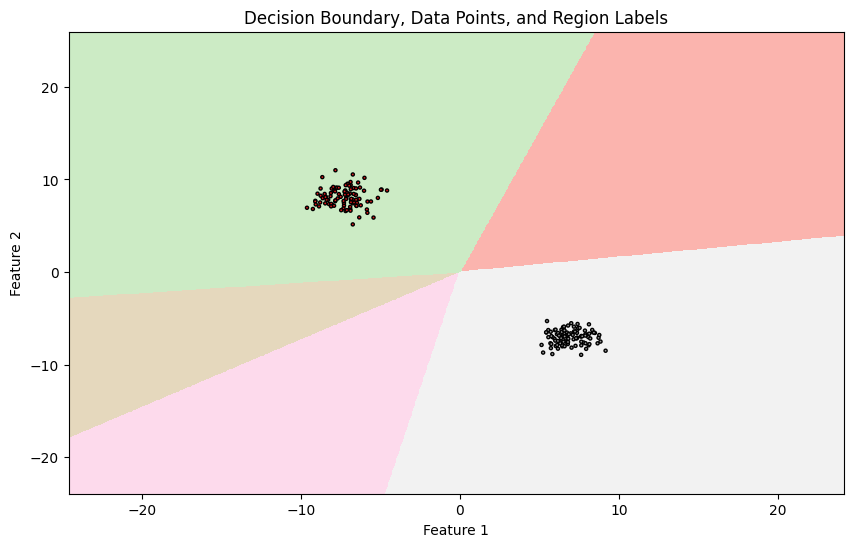

In [54]:
linear_probe = LinearProbe(INPUT_DIM, NUM_CLASSES)
optimizer = optim.SGD(linear_probe.parameters(), lr=0.1)

linear_probe.apply(init_weights_to_zero)
train_incrementally(NUM_EPOCHS, X, y, linear_probe, loss_criterion, optimizer, min_delta=0.01)

The classes being predicted by the model are:  [1 3 5 6 7]


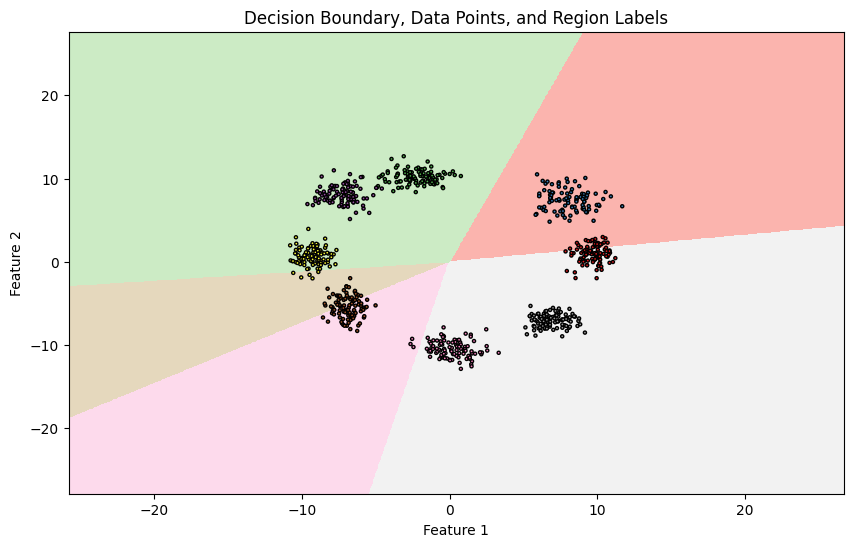

In [55]:
plot_datapoints_and_decision_boundary(linear_probe, X, y)

In [56]:
class NaiveMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = self.hidden_layer(x)
        activations = self.relu(h)
        z = self.output_layer(activations)
        return z

Training period  1 started
Classes being trained on are: [0, 4]
Epoch 1/1000, Loss: 0.0032
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 1 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 4]


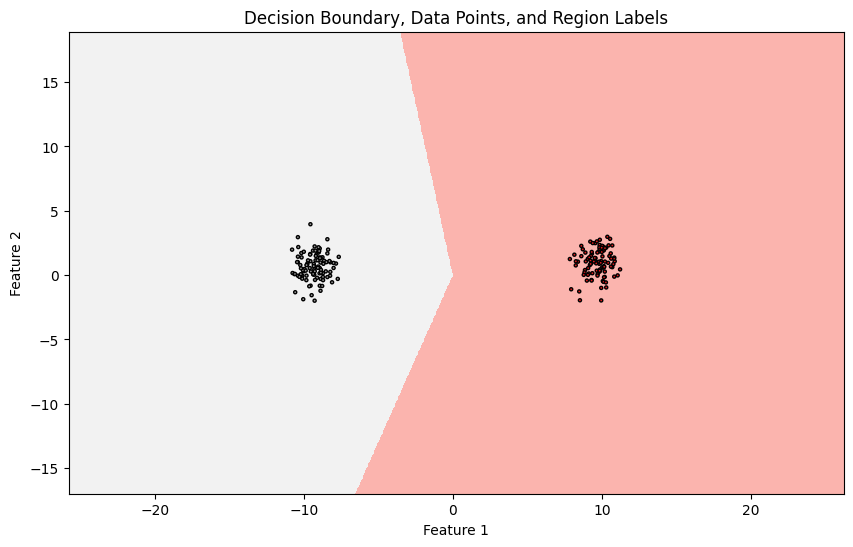

Training period  2 started
Classes being trained on are: [1, 5]
Epoch 1/1000, Loss: 0.0030
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 2 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 1 4 5]


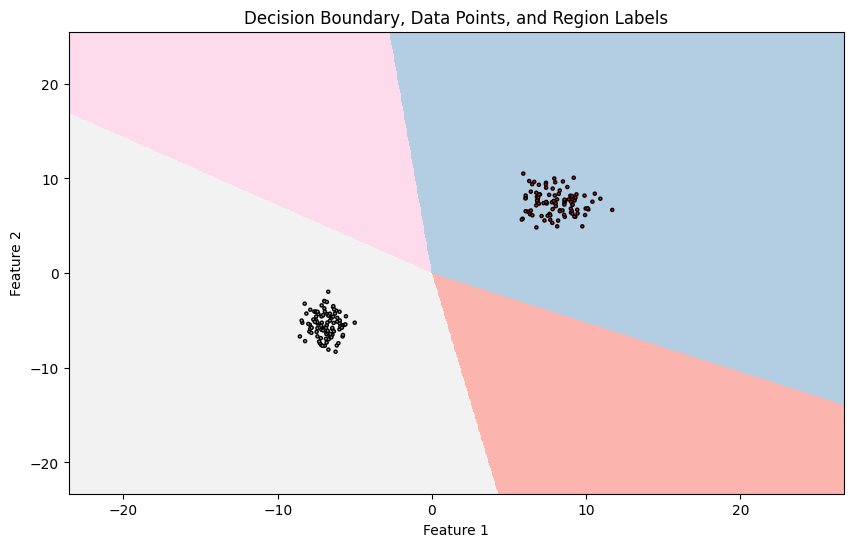

Training period  3 started
Classes being trained on are: [2, 6]
Epoch 1/1000, Loss: 0.0056
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0001
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 3 completed; last epoch run = 1000
The classes being predicted by the model are:  [1 2 5 6]


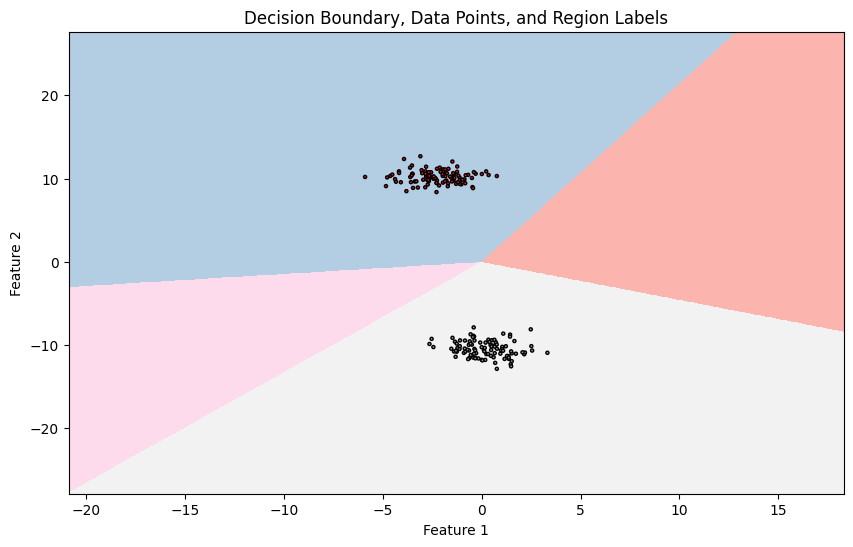

Training period  4 started
Classes being trained on are: [3, 7]
Epoch 1/1000, Loss: 0.0007
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 4 completed; last epoch run = 1000
The classes being predicted by the model are:  [1 2 3 5 6 7]


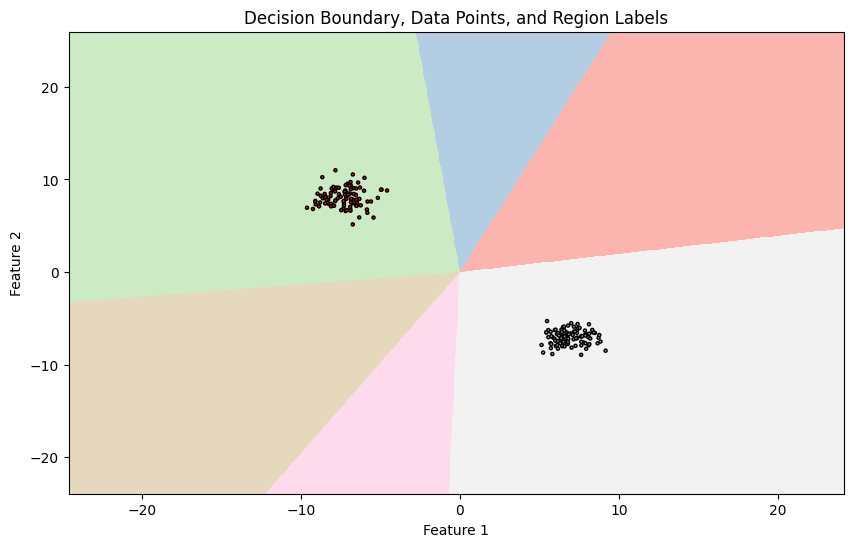

In [57]:
naiveMLP32 = NaiveMLP(INPUT_DIM, 32, NUM_CLASSES)
optimizer = optim.SGD(naiveMLP32.parameters(), lr=0.01)

naiveMLP32.apply(init_weights_kaiming)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_incrementally(NUM_EPOCHS, X, y, naiveMLP32, loss_criterion, optimizer)

The classes being predicted by the model are:  [1 2 3 5 6 7]


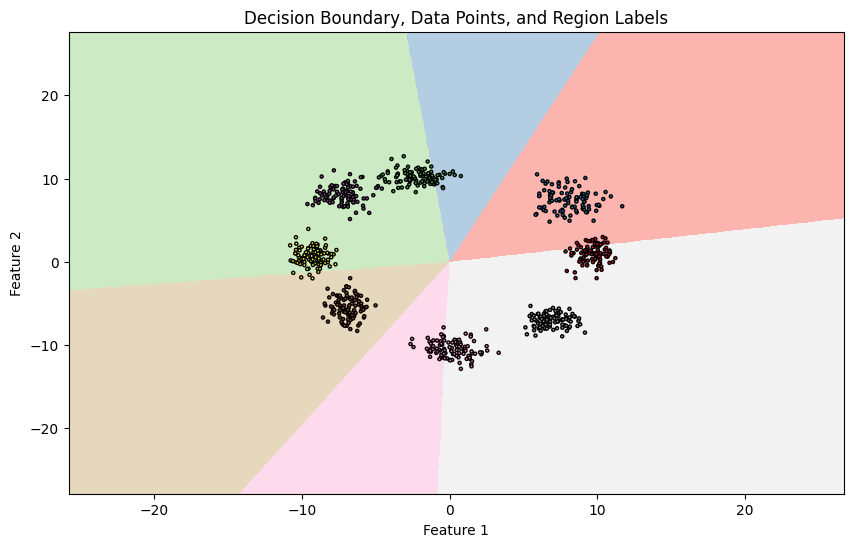

In [58]:
plot_datapoints_and_decision_boundary(naiveMLP32, X, y)

Training period  1 started
Classes being trained on are: [0, 4]
Epoch 1/1000, Loss: 2.0797
Epoch 101/1000, Loss: 1.7215
Epoch 201/1000, Loss: 1.4247
Epoch 301/1000, Loss: 1.1675
Epoch 401/1000, Loss: 0.9778
Epoch 501/1000, Loss: 0.8059
Epoch 601/1000, Loss: 0.6698
Epoch 701/1000, Loss: 0.5497
Epoch 801/1000, Loss: 0.4880
Epoch 901/1000, Loss: 0.3917
Training period 1 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 4]


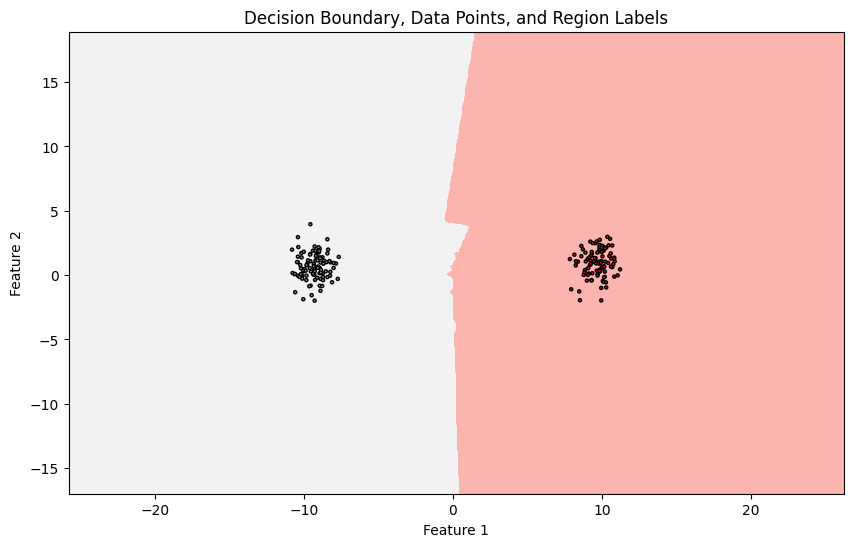

Training period  2 started
Classes being trained on are: [1, 5]
Epoch 1/1000, Loss: 2.3485
Epoch 101/1000, Loss: 1.9848
Epoch 201/1000, Loss: 1.5942
Epoch 301/1000, Loss: 1.2889
Epoch 401/1000, Loss: 1.0779
Epoch 501/1000, Loss: 0.8650
Epoch 601/1000, Loss: 0.7388
Epoch 701/1000, Loss: 0.5946
Epoch 801/1000, Loss: 0.5591
Epoch 901/1000, Loss: 0.4400
Training period 2 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 1 4 5]


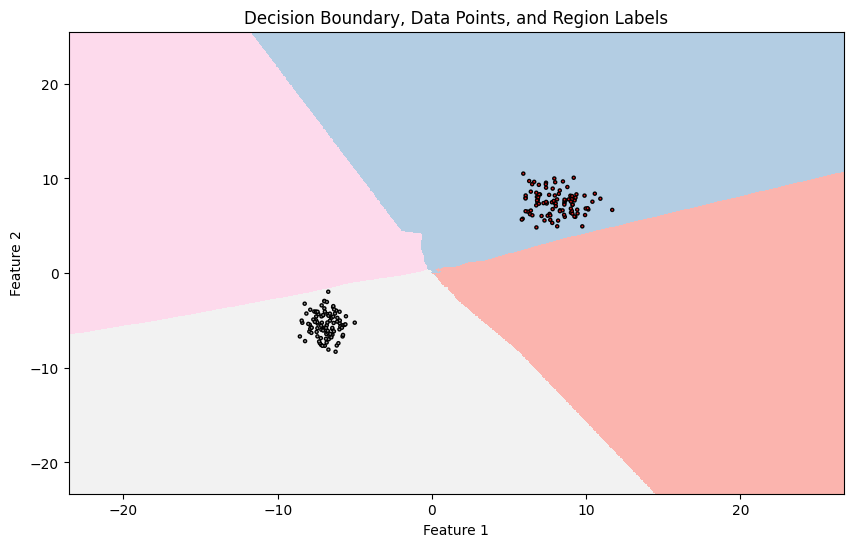

Training period  3 started
Classes being trained on are: [2, 6]
Epoch 1/1000, Loss: 2.4001
Epoch 101/1000, Loss: 2.0298
Epoch 201/1000, Loss: 1.6548
Epoch 301/1000, Loss: 1.3545
Epoch 401/1000, Loss: 1.1222
Epoch 501/1000, Loss: 0.9331
Epoch 601/1000, Loss: 0.7367
Epoch 701/1000, Loss: 0.6416
Epoch 801/1000, Loss: 0.5578
Epoch 901/1000, Loss: 0.4653
Training period 3 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 1 2 4 5 6]


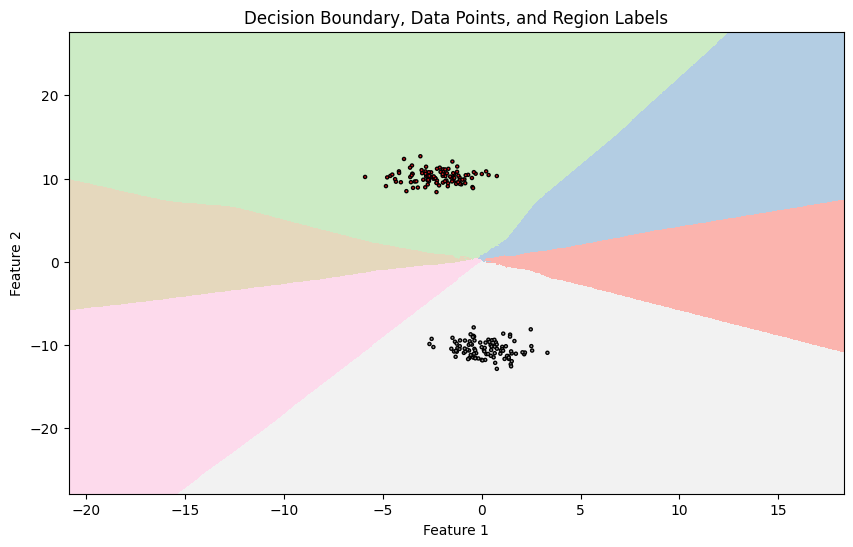

Training period  4 started
Classes being trained on are: [3, 7]
Epoch 1/1000, Loss: 2.8056
Epoch 101/1000, Loss: 2.3034
Epoch 201/1000, Loss: 1.8614
Epoch 301/1000, Loss: 1.5127
Epoch 401/1000, Loss: 1.1933
Epoch 501/1000, Loss: 0.9679
Epoch 601/1000, Loss: 0.7587
Epoch 701/1000, Loss: 0.6516
Epoch 801/1000, Loss: 0.5311
Epoch 901/1000, Loss: 0.4242
Training period 4 completed; last epoch run = 1000
The classes being predicted by the model are:  [0 1 2 3 4 5 6 7]


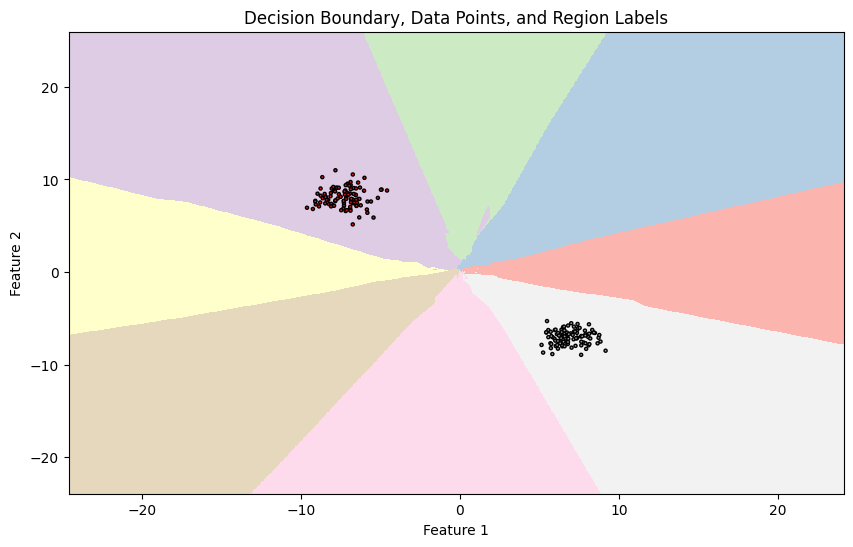

In [59]:
from SimpleDiscreteKeyValueBottleneck import SimpleDiscreteKeyValueBottleneck

simple_dkvb = SimpleDiscreteKeyValueBottleneck(num_codebooks=20,
                                  embed_dim=2,
                                  value_dim=8,
                                  keys_per_codebook=20,
                                  requires_random_projection=True)

simple_dkvb.apply(init_weights_kaiming)
optimizer = optim.SGD(simple_dkvb.parameters(), lr=0.01)
train_incrementally(NUM_EPOCHS, X, y, simple_dkvb, loss_criterion, optimizer)

The classes being predicted by the model are:  [0 1 2 3 4 5 6 7]


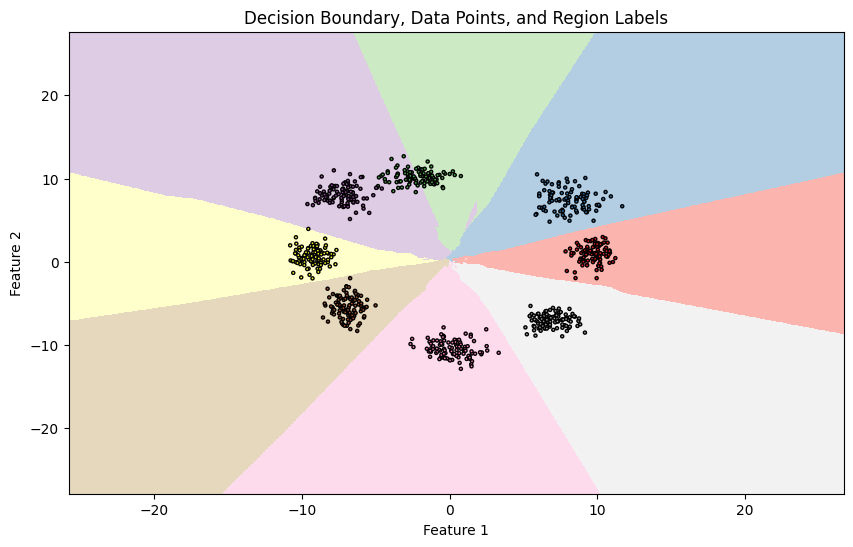

In [60]:
plot_datapoints_and_decision_boundary(simple_dkvb, X, y)